# Library

In [1]:
import os
import tensorflow as tf

In [2]:
import numpy as np

In [3]:
import pandas as pd

In [4]:
import nltk
from nltk.tokenize import word_tokenize

In [5]:
import random as rnd

In [6]:
from keras.preprocessing.sequence import pad_sequences

In [7]:
from pickle import dump
from pickle import load

In [8]:
from keras.preprocessing.text import Tokenizer

In [9]:
import numpy as np

In [10]:
import keras.backend as K
import tensorflow as tf

In [11]:
from keras.layers import LSTM

In [12]:
from keras.layers import Input,Dropout,LSTM,Lambda,Bidirectional
from keras import Sequential
from keras.utils import plot_model
from keras.models import Model
from keras.optimizers import Adam

In [13]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import History
from keras.models import load_model

In [14]:
from tensorflow.math import reduce_sum

In [15]:
from keras.layers import Concatenate,Add,Subtract,Multiply

In [16]:
import re

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
os.chdir('/content/drive/MyDrive/Quora Similarity/')

In [19]:
os.getcwd()

'/content/drive/MyDrive/Quora Similarity'

# Data Preprocesing

In [20]:
df= pd.read_csv('questions.csv')

In [21]:
df = df.drop(['id','qid1','qid2'],axis=1)

In [22]:
df.head()

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [23]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [24]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [25]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = " ".join(text)
    return text


In [27]:
df['question1'] = df.question1.apply(lambda x: clean_text(str(x)))
df.head()

,question1,question2,is_duplicate
0,what be the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,what be the story of kohinoor kohinoor diamond,What would happen if the Indian government sto...,0
2,how can i increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,why be i mentally very lonely how can i solve it,Find the remainder when [math]23^{24}[/math] i...,0
4,which one dissolve in water quikly sugar salt ...,Which fish would survive in salt water?,0


In [28]:
df['question2'] = df.question2.apply(lambda x: clean_text(str(x)))
df.head()

,question1,question2,is_duplicate
0,what be the step by step guide to invest in sh...,what be the step by step guide to invest in sh...,0
1,what be the story of kohinoor kohinoor diamond,what would happen if the indian government ste...,0
2,how can i increase the speed of my internet co...,how can internet speed be increase by hack thr...,0
3,why be i mentally very lonely how can i solve it,find the remainder when math2324math be divide...,0
4,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0


In [29]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D, concatenate, dot
from keras.models import Model, Sequential

In [30]:
total_text = pd.concat([df['question1'], df['question2']]).reset_index(drop=True)
max_features = 6000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(total_text)
question_1_sequenced = tokenizer.texts_to_sequences(df['question1'])
question_2_sequenced = tokenizer.texts_to_sequences(df['question2'])

In [31]:
maxlen = 100
question_1_padded = pad_sequences(question_1_sequenced, maxlen=maxlen)
question_2_padded = pad_sequences(question_2_sequenced, maxlen=maxlen)


In [32]:
y = df['is_duplicate']

In [33]:
word_index = tokenizer.word_index

# Model

In [41]:
embedding_size = 128

inp1 = Input(shape=(100,))
inp2 = Input(shape=(100,))

siamese_net=Sequential()
siamese_net.add(Embedding(max_features, embedding_size,trainable=True))
siamese_net.add(Bidirectional(LSTM(32, return_sequences = False)))
siamese_net.add(Dense(64,activation='tanh'))
siamese_net.add(Dense(32,activation='tanh'))
siamese_net.add(Dense(16,activation='tanh'))


x3 = siamese_net(inp1)
x4 = siamese_net(inp2)

x5 = Subtract()([x3,x4])
x5= reduce_sum(x5,keepdims=True,axis=1)
#x5 = Multiply()([x5,x5])
#x5 = Dense(8,activation='tanh')(x5)
#x5 = Dense(1,activation='tanh')(x5)

#x6 = Add()([x3,x4])
#x6 = Multiply()([x6,x6])
#x6 = Dense(8,activation='tanh')(x6)
#x6 = Dense(1,activation='tanh')(x6)
#x6 = GlobalMaxPool1D()(x4)

x7 =  dot([x3, x4], axes=1,name='dot')

conc=Concatenate(axis=-1)([x5,x7])
#x8 = Dense(40, activation='relu')(conc)
#x9 = Dropout(0.05)(x8)
x10 = Dense(3, activation='relu')(conc)
output = Dense(1, activation="sigmoid")(x10)

In [42]:
model = Model(inputs=[inp1, inp2], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 100

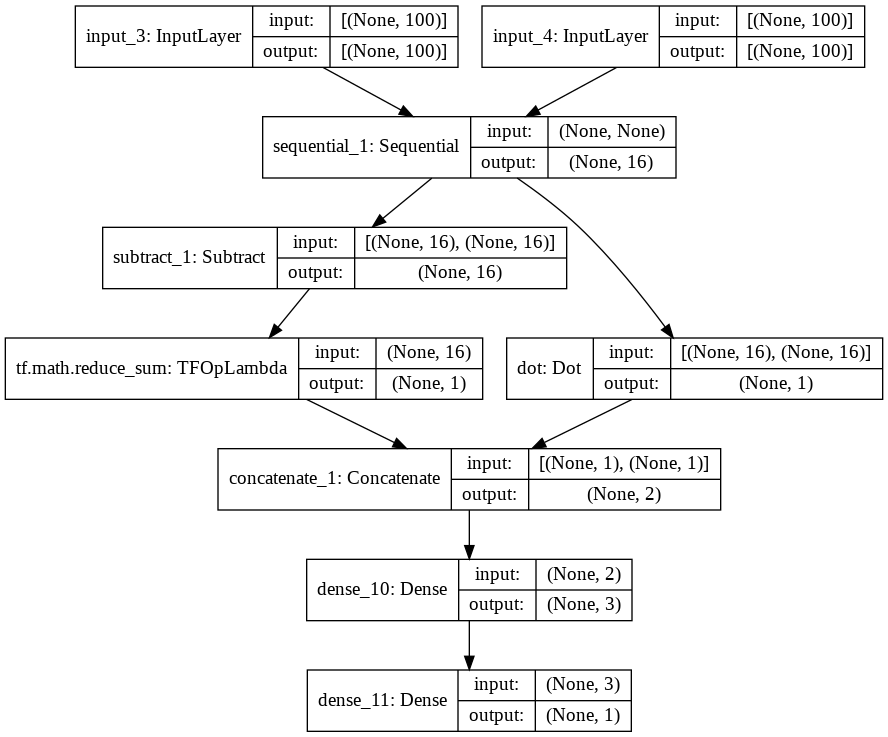

In [43]:
plot_model(model, to_file='model_2.png', show_shapes=True)

In [44]:
for layers in model.layers:
  print(layers.name," ",layers.trainable)

input_3   True
input_4   True
sequential_1   True
subtract_1   True
tf.math.reduce_sum   True
dot   True
concatenate_1   True
dense_10   True
dense_11   True


In [45]:
model_checkpoint = ModelCheckpoint('bst_model.h5', save_best_only=True, save_weights_only=True)

In [48]:
callback=EarlyStopping('val_accuracy',patience=3)
batch_size = 346

In [49]:
model.fit([question_1_padded, question_2_padded], y, batch_size=batch_size, epochs=epochs, validation_split=0.2,callbacks=[callback,model_checkpoint])

Epoch 1/100
935/935 [==============================] - 46s 49ms/step - loss: 0.2446 - accuracy: 0.9078 - val_loss: 0.4553 - val_accuracy: 0.8176
Epoch 2/100
935/935 [==============================] - 46s 49ms/step - loss: 0.2244 - accuracy: 0.9173 - val_loss: 0.4662 - val_accuracy: 0.8181
Epoch 3/100
935/935 [==============================] - 46s 49ms/step - loss: 0.2066 - accuracy: 0.9256 - val_loss: 0.4785 - val_accuracy: 0.8197
Epoch 4/100
935/935 [==============================] - 46s 49ms/step - loss: 0.1913 - accuracy: 0.9326 - val_loss: 0.4923 - val_accuracy: 0.8208
Epoch 5/100
935/935 [==============================] - 46s 49ms/step - loss: 0.1774 - accuracy: 0.9386 - val_loss: 0.5113 - val_accuracy: 0.8204
Epoch 6/100
935/935 [==============================] - 46s 49ms/step - loss: 0.1640 - accuracy: 0.9443 - val_loss: 0.5218 - val_accuracy: 0.8208
Epoch 7/100
935/935 [==============================] - 46s 49ms/step - loss: 0.1536 - accuracy: 0.9491 - val_loss: 0.5346 - val_ac